# 6장 결정 트리

## 6.1 결정 트리 학습과 시각화

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [9]:
print(os.getcwd())

C:\Users\user\road_to_master\Hands on Machine Learning


In [21]:
!pip install pydot

In [42]:
from sklearn.tree import export_graphviz
import os, pydot
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

export_graphviz(
        tree_clf,
        out_file=image_path("iris_tree.dot"),
        feature_names=["꽃잎 길이 (cm)", "꽃잎 너비 (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

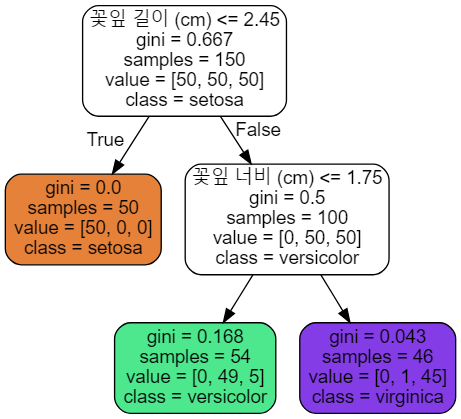

## 6.2 예측하기

트리가 어떻게 예측하는지 알아보자.  
먼저 __루트 노드__(맨꼭대기의 노드) 에서 이 노드는 꽃잎의 길이가 2.45cm보다 짧은지 검사한다. 만약 그렇다면 루트 노드에서 왼쪽의 __자식노드__로 이동하고 이경우가 __리프노드__이므로 추가적인 검사를 하지않는다. 그냥 노드에 있는 예측 클래스를 보고 결정 트리가새로 발견한 꽃의 품종을 Setosa로 예측한다.

또 다른 꽃을 발견햇는데 이번에는 2.45보다 길었다고 가정하자. 그러면 오른쪽 노드로 이동한다. 이 노드는 리프노드가 아니라서 추가로 '꽃잎의 너비가 1.75보다 작은지' 검사한다. 만약 그렇다면 이꽃은 아마도 Versicolor이고 아니라면 virginica로 분류한다.

`Tip`  
결정트리의 장점중 하나는 데이터 전처리가 거의 필요없다는 것이다. 특히 특성의 스케일을 맞추거나 평균을 원점에 맞추는 작업이 필요하지 않다.

노드의 sample 속성은 얼마나 많은 훈련 샘플이 적용되었는지 헤아린 것.  

노드의 gini 속성은 __불순도__를 측정한것. 한 노드의 모든 샘플이 같은 클래스에 속해 있다면 이 노드를 순수(gini=0)하다고 한다.  
예를들어 깊이 2의 왼쪽 노드의 gini 점수는 $1-(0/54)^2-(40/54)^2-(5/54)^2 = 0.168$ 이다. 

지니 불순도 => $G_i = 1 - \sum p_{i,k}^2$  
여기서 $p_{i,k}$는 i번째 노드에 있는 훈련 샘플 중 클래스 k에 속한 샘플의 비율

`NOTE`  
사이킷런은 __이진트리__만 만드는 CART 알고리즘을 사용한다. 그러므로 리프 노드 이외의 모든 노드는 자식노드를 2개씩 가진다.  
하지만 ID3 같은 알고리즘은 둘 이상의 자식 노드를 가진 결정 트리를 만들 수 있다.

## 6.3 클래스 확률 추정

결정 트리는 한 샘플이 특정 클래스 k에 속할 확률을 추정할 수도 있다.  
먼저 이 샘플에 대해 리프 노드를 찾기 위해 트리를 탐색하고 그 노드에 있는 클래스 k의 훈련 샘플의 비율을 반환한다.  예를들어 길이가 5이고 너비가 1.5인 꽃잎을 발견했다고 가정하자. 이에 해당하는 리프 노드는 깊이 2의 왼쪽 노드이므로 결정 트리는 그에 해당하는 확률을 출력한다.  
즉 Setosa는 0% (0/54) Versicolor는 90.7%(49/54), Virginica는 9.3%(5/54) 당연히 클래스 하나를 예측한다면 Versicolor를 예측 할것이다.  

In [66]:
tree_clf.predict_proba([[5,1.5]]), tree_clf.predict([[5,1.5]])

(array([[0.        , 0.90740741, 0.09259259]]), array([1]))

1을 예측했다는 것은 Versicolor 예측확률은 손으로 계산한것과 동일!

## 6.4 CART 훈련 알고리즘

사이킷런은 결정 트리를 훈련시키기 위해 CART 알고리즘을 사용한다.  
알고리즘 : 먼저 훈련세트를 하나의 특성 k의 임곗값 $t_k$르 사용해 두개의 서브셋으로 나눈다.  
어떻게 k와 $t_k$를 고를까?  
크기에 따른 서브셋으로 나눌 수 있는 (k, $t_k$) 짝을 찾는다. 
이 알고리즘이 최소화 해야하는 비용함수는 

$J(k,t_k )=m_{left}/m \times G_{left}+m_{right}/m \times G_{right}$

$G_{left/right}$는 왼쪽/오른쪽 서브셋의 불순도  
$m_{left/right}$는 왼쪽/오른쪽 서브셋의 샘플 수 

훈련 세트를 성공적으로 둘로 나누었다면 같은 방식으로 서브셋을 또 나누고 그다음엔 서브셋의 서브셋을 나누고 이런식으로 계속 반복한다.  
이 과정은 최대 깊이가 되면 중지하거나 불순도를 줄이는 분할을 찾을 수 없을때 멈춘다.  
다른 몇 개의 매개변수도 중지 조건에 관여한다.  
(ex : min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_leaf_nodes)

`CAUTION`  
CART 알고리즘은 __탐욕적 알고리즘__이다.  
맨위 루트노드에서 최적의 분할을 찾으며 각 단계에서 이 과정을 반복한다. 현재 단계의 분할이 몇 단계를 거쳐 가장 낮은 불순도로 이어질 수 있을지 없을지는 고려하지 않는다.  
탐욕적 알고리즘은 종종 납득할만한 훌륭한 솔루션을 만들어내지만 최적의 솔루션을 보장하지는 않는다.

Unfortunately, 최적의 트리를 찾는 것은 __NP-완전__ 문제로 알려져 있다. 
$O(exp(m))$시간이 필요하고 매우 작은 훈련세트에도 적용되기 어렵다. 그러므로 `납득할만한 솔루션`으로 만족해야한다.

## 6.5 계산 복잡도

예측을하려면 결정 트리를 루트 노드에서부터 리프노드까지 탐색해야한다.  
일반적으로 결정 트리는 거의 균형을 이루고 있으므로 결정 트리를 탐색하기 위해서는 약 $O(log_2(m))$개의 노드를 거쳐야한다. 그래서 큰 훈련세트를 다룰 떄도 예측 속도가 빠르다.

그러나 훈련 알고리즘은 각 노드에서 모든 훈련 샘플의 모든 특성을 비교한다(max_features가 지정되었다면 그거보다는 적음) .  그래서 훈련 복잡도는 $O(n \times mlog(m))$

훈련 세트가 (수천개 이하로) 작을 경우 사이킷런은 presort = True로 지정하면 미리데이터를 정렬하여 훈련속도를 높일 수 있다. 하지만 훈련 세트가 클 경우에는 속도가 많이 느려진다.

## 6.6 지니 불순도 또는 엔트로피?


기본적으로는 지니 불순도가 사용되지만 criterion 매개변수를 "entropy"로 지정하여 엔트로피 불순도를 사용할 수 있다.  
머신러닝에서는 불순도 측정 방법으로 사용된다.  어떤 세트가 한 클래스의 샘플만 담고 있따면 엔트로피가 0이다.  

$H_i = -\sum p_{i,k}log_2(p_{i,k})$

그럼 둘중 무엇을 사용해야할까? 실제로는 큰차이가 없고 지니 불순도가 조금 더 계산이 빠르기 때문에 기본 값으로 좋다.  
그러나 다른 트리가 만들어지는 경우 지니 불순도가 가장 빈도 높은 클래스를 한쪽 가지로 고립시키는 경향이 있는 반면 엔트로피는 조금더 균형잡힌 트리를 만든다.

## 6.7 규제 매개변수

결정 트리는 훈련 데이터에 대한 제한 사항이 거의 없다.(반대로 선형 모델은 데이터가 꼭 선형일거라 가정함)  
제한을 두지 않으면 트리가 훈련 데이터에 아주 가깝게 맞추려고해서 과대적합 되기가 쉽다.  
결정트리는 훈련 전에 파라미터 수가 결정 되지 않기 때문에 Nonparametric model이라고 부른다.  
모델 구조가 데이터에 맞춰져서 고정되지 않고 자유롭다.  
반대로 선형모델같은 parametric model은 미리 정의된 모델 파라미터 수를 가지므로 자유도가 제한되고 과대적합 될 위험이 줄어든다. (반대로 과소적합될 위험은 커진다)  
------------------------------------------------
훈련데이터에 대한 과대적합을 피하기위해 결정 트리의 자유도를 제한할 필요가 있다.  
사이킷런의 max_depth로 결정 트리의 최대 깊이를 제어할 수 있다.
DecisionTreeClassifier에는 비슷하게 결정 트리의 형태를 제한하는 다른 매개변수가 몇개 있다.
- min_samples_split : 분할되기 위해 노드가 가져야하는 최소 샘플 수 
- min_samples_leaf : 리프 노드가 가지고 있어야 할 최소 샘플 수 
- min_weight_fraction_leaf : min_samples_leaf와 같지만 가중치가 부여된 전체 샘플에서의 비율
- max_leaf_nodes : 리프 노드의 최대 수
- max_features : 각 노드에서 분할에 사용할 특성의 최대 수

*min_으로 시작하는 매개변수를 증가시키거나 max_로 시작하는 매개변수를 감소시키면 모델에 규제가 커진다.*

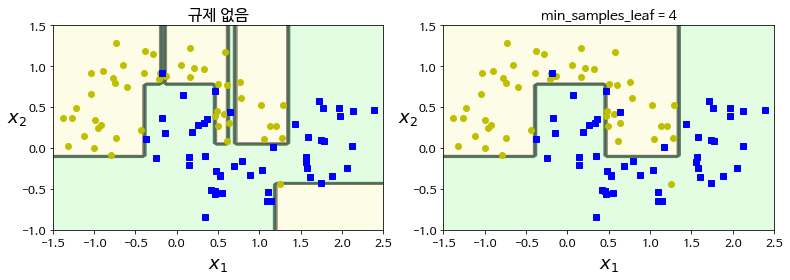

위는 규제가 있는 경우와 없는 경우의 트리 결정경계


`Note`  
제한없이 결정 트리를 훈련시키고 불필요한 노드를 가지치기하는 알고리즘도 있다 (__Post_pruning__) 순도를 높이는 것이 통계적으로 큰 효과가 없다면 리프 노드 바로 위의 노드는 불필요할 수도 있다. 대표적으로 $\chi^2$ 검정 같은 통계적 검정을 사용하여 우연히 향상 된 것인지 추정한다.가지치기는 불필요한 노드가 모두 없어질때까지 계속된다.

## 6.8 회귀

In [69]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth = 2)
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

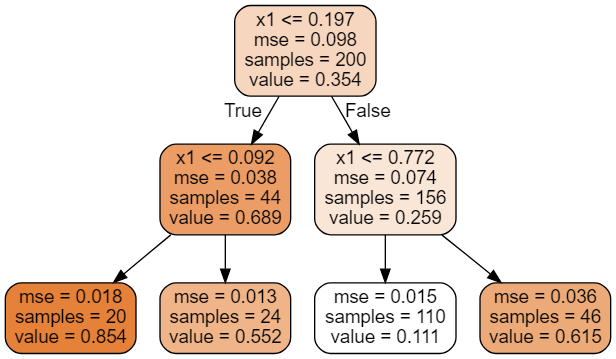

앞선 분류트리와 비슷해보이지만 각 노드에서 클래스를 예측하는 대신 어떤 값(value)를 예측한다는 점이다르다. 

예를 들면, $x_1$ = 0.6 인 샘플의 클래스를 예측하면 흰색 박스 리프노드로 들어가게되는데 이 리프노드에 있는 110개 훈련 샘플의 평균 타깃값이 예측값이된다. 이 예측값을 사용해 110개 샘플에 대한 MSE를 계산하면 0.0151이 된다.

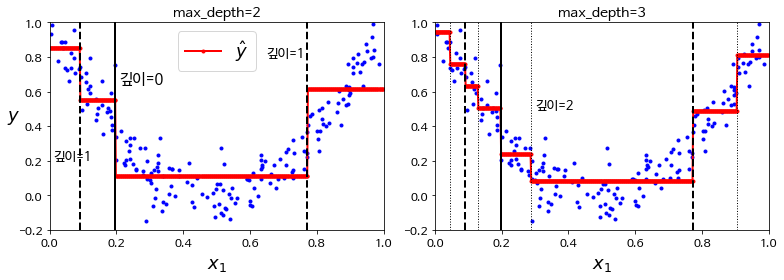

좌측은 max_depth = 2 일때 결정경계, 우측은 max_depth = 3일때 결정 경계

CART 알고리즘은 분류에서와 다르게 회귀에서는 불순도를 최소화하는 방향으로 분할하는 대신 평균제곱오차(MSE)를 최소화하다록 분할한다.  
이점을 제외하고는 분류의 경우와 거의 동일하게 작동

$J(k,t_k )=m_{left}/m \times MSE_{left}+m_{right}/m \times MSE_{right}$

$MSE_{node} = \sum(y_{node} - y^{(i)})^2$  
$y_{node} = 1/(m_{node})\sum y^{(i)}$

분류에서와 마찬가지로 회귀에서도 과적합 되기가 쉽다.  


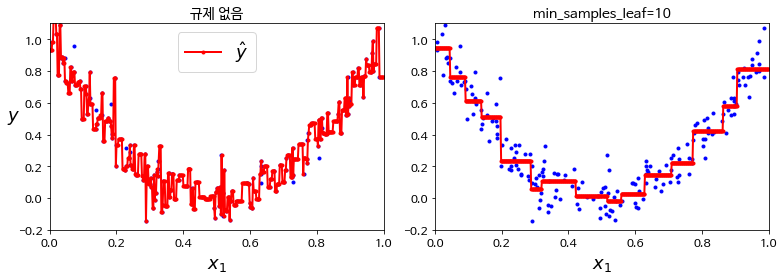

왼쪽 이미지는 규제가 전혀 없을때 결정트리, 오른쪾은 min_samples_leaf = 10 규제를 주어 그러싸한 모델을 만들었음. 

### 6.9 불안정성

결정트리는 이해하고 해석하기 쉽고 사용하기 편하고 여러 용도로 사용할 수 있으며 성능도 뛰어나다.  
하지만  
결정트리는 계단 모양의 결정경계를 만든다 그래서 훈련세트의 회전에 굉장히 민감하다.  
아래 이미지를 보면 선분하나로 쉽게 결정경계를 만들 수 잇는데 데이터의 회전 만으로 구불구불한 결정 경계가 만들어 졌다.  
두 결정 트리 모두 훈련세트를 완벽하게 학습하지만, 오른쪽 결정경계는 잘 일반화 될 것 같지 않다.  
이런 문제는 해결하는 방법 중 하나는 PCA기법을 사용하는 것이다.  

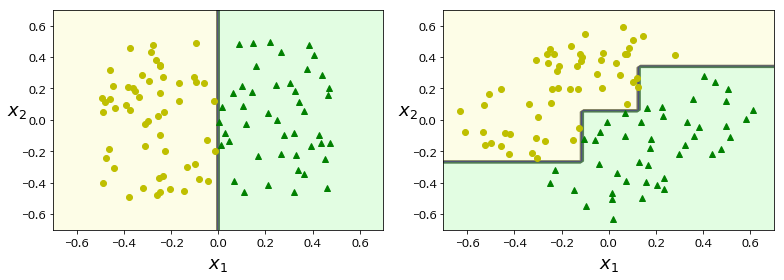

결정 트리의 또 다른 문제는 훈련 데이터에 있는 작은 변화에도 민감하다는 것이다.(outlier)  
사이킷런에서 사용하는 훈련 알고리즘은 확률적(각노드에서 평가할 후보특성을 무작위 선택) 이기 때문에 같은 훈련데이터셋에서도 다른 결과를 얻을 수도 있다.  
RandomForest는  많은 트리에서 만든 예측을 평균하여 이런 불안정성을 극복 할 수 있다.  



### 6.10 연습문제